Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`) using a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.


- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do exploratory visualizations with Seaborn.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Fit a linear regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way (without an excessive amount of formulas or academic pre-requisites).
(That book is good regardless of whether your cultural worldview is inferential statistics or predictive machine learning)
- [ ] Read Leo Breiman's paper, ["Statistical Modeling: The Two Cultures"](https://projecteuclid.org/download/pdf_1/euclid.ss/1009213726)
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html):

> Pipeline can be used to chain multiple estimators into one. This is useful as there is often a fixed sequence of steps in processing the data, for example feature selection, normalization and classification. Pipeline serves multiple purposes here:

> - **Convenience and encapsulation.** You only have to call fit and predict once on your data to fit a whole sequence of estimators.
> - **Joint parameter selection.** You can grid search over parameters of all estimators in the pipeline at once.
> - **Safety.** Pipelines help avoid leaking statistics from your test data into the trained model in cross-validation, by ensuring that the same samples are used to train the transformers and predictors.

In [1]:
# If you're in Colab...
import os, sys
in_colab = 'google.colab' in sys.modules

if in_colab:
    # Install required python packages:
    # category_encoders, version >= 2.0
    # pandas-profiling, version >= 2.0
    # plotly, version >= 4.0
    !pip install --upgrade category_encoders pandas-profiling plotly
    
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Change into directory for module
    os.chdir('module3')

     |████████████████████████████████| 92kB 6.0MB/s 
     |████████████████████████████████| 133kB 15.4MB/s 
Requirement already up-to-date: plotly in /usr/local/lib/python3.6/dist-packages (4.1.1)
     |████████████████████████████████| 614kB 35.8MB/s 
     |████████████████████████████████| 225kB 43.1MB/s 
     |████████████████████████████████| 768kB 37.2MB/s 
     |████████████████████████████████| 194kB 41.4MB/s 
     |████████████████████████████████| 51kB 15.4MB/s 
     |████████████████████████████████| 737kB 37.8MB/s 
     |████████████████████████████████| 51kB 19.2MB/s 
  Created wheel for pandas-profiling: filename=pandas_profiling-2.3.0-py2.py3-none-any.whl size=145035 sha256=a644e026d85c19134a9c00bbeaa89eda8a0ba4ea889d0b0771d95a9d91e0c8df
  Stored in directory: /root/.cache/pip/wheels/ce/c7/f1/dbfef4848ebb048cb1d4a22d1ed0c62d8ff2523747235e19fe
  Created wheel for htmlmin: filename=htmlmin-0.1.12-cp36-none-any.whl size=27084 sha256=d70420602f541b55213454a2718a83e423f3cfae

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

### Import With Symbol Replacements.

In [3]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer.
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,CHELSEA,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,FASHION,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,FASHION,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,GREENWICH VILLAGE-WEST,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


### Create Parameters, Filter Data Set Requirements, One Hot Encode 'Neighborhood'.

In [4]:
# create a copy of the data frame.
df1 = df.copy()
# single out the '01 ONE FAMILY DWELLINGS' value.
df1 = df1[(df1['BUILDING_CLASS_CATEGORY'] == '01 ONE FAMILY DWELLINGS')]
# set the minimum sale price.
df1 = df1[(df1['SALE_PRICE'] > 100000)]
# set the maximum sale price.
df1 = df1[(df1['SALE_PRICE'] < 2000000)]
# change 'NEIGHBORHOOD' column type to 'categoty' type.
df1['NEIGHBORHOOD'] = df1['NEIGHBORHOOD'].astype('category')
# create a new column with the 'category' values from 'NEIGHBORHOOD' column.
df1['NID'] = df1['NEIGHBORHOOD'].cat.codes
# create a full address by adding ' NEW YORK, NY ' to the 'ADDRESS' column.
df1['FULL_ADDRESS'] = df1['ADDRESS'] + ' NEW YORK, NY '
# show the data frame with headers.
df1.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE,NID,FULL_ADDRESS
44,3,OCEAN PARKWAY-NORTH,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019,124,"4832 BAY PARKWAY NEW YORK, NY"
61,4,QUEENS VILLAGE,01 ONE FAMILY DWELLINGS,1,7918,72,NaN,A1,80-23 232ND STREET,NaN,11427.0,1.0,0.0,1.0,"4,000",2001.0,1940.0,1,A1,200000,01/01/2019,137,"80-23 232ND STREET NEW YORK, NY"
78,2,PELHAM PARKWAY SOUTH,01 ONE FAMILY DWELLINGS,1,4210,19,NaN,A1,1260 RHINELANDER AVE,NaN,10461.0,1.0,0.0,1.0,"3,500",2043.0,1925.0,1,A1,810000,01/02/2019,132,"1260 RHINELANDER AVE NEW YORK, NY"
108,3,FLATBUSH-CENTRAL,01 ONE FAMILY DWELLINGS,1,5212,69,NaN,A1,469 E 25TH ST,NaN,11226.0,1.0,0.0,1.0,"4,000",2680.0,1899.0,1,A1,125000,01/02/2019,58,"469 E 25TH ST NEW YORK, NY"
111,3,FLATBUSH-EAST,01 ONE FAMILY DWELLINGS,1,7930,121,NaN,A5,5521 WHITTY LANE,NaN,11203.0,1.0,0.0,1.0,"1,710",1872.0,1940.0,1,A5,620000,01/02/2019,59,"5521 WHITTY LANE NEW YORK, NY"


### Train/Test Data Split on Sale Date WITH DateTime.

In [0]:
# use pd.to_datetime on the 'SALE_DATE' column.
df1['SALE_DATE'] = pd.to_datetime(df1['SALE_DATE'], infer_datetime_format=True)

In [6]:
# split the train/test data on the dates listed.
train = df1[(df1['SALE_DATE'] > '2018-12-31') & (df1['SALE_DATE'] < '2019-04-01')]
test  = df1[(df1['SALE_DATE'] >= '2019-04-01')]
# show the shape of each data frame.
print("Train Dataset 'Jan 2019 through Mar 2019':", train.shape)
print("Test Dataset'Apr 2019':", test.shape)

Train Dataset 'Jan 2019 through Mar 2019': (2507, 23)
Test Dataset'Apr 2019': (644, 23)


### Features Unique Value vs Sale Price Plotting.

In [0]:
# import matplot.lib, seaborn libraries.
import matplotlib.pyplot as plt
import seaborn as sns 

In [39]:
# check the cardinatlity, how many unique values for the 'categorical' features.
train.describe(exclude= 'number').T.sort_values(by = 'unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,2507,1,01 ONE FAMILY DWELLINGS,2507,NaN,NaN
APARTMENT_NUMBER,1,1,RP.,1,NaN,NaN
TAX_CLASS_AT_PRESENT,2507,2,1,2476,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,2507,11,A1,919,NaN,NaN
BUILDING_CLASS_AT_PRESENT,2507,13,A1,919,NaN,NaN
SALE_DATE,2507,68,2019-01-31 00:00:00,78,2019-01-01 00:00:00,2019-03-30 00:00:00
NEIGHBORHOOD,2507,176,FLUSHING-NORTH,77,NaN,NaN
LAND_SQUARE_FEET,2507,887,"4,000",234,NaN,NaN
ADDRESS,2507,2497,125-27 LUCAS STREET,2,NaN,NaN
FULL_ADDRESS,2507,2497,"57 CHESTNUT STREET NEW YORK, NY",2,NaN,NaN


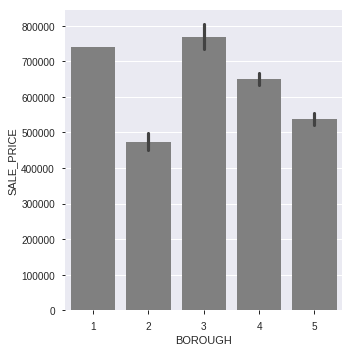

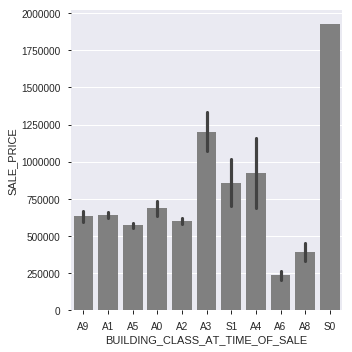

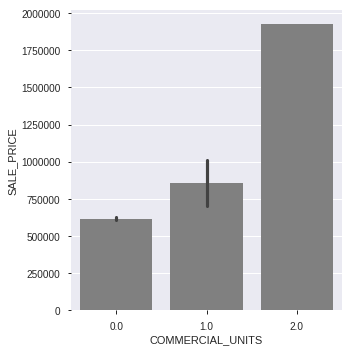

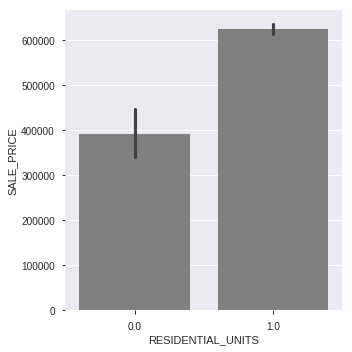

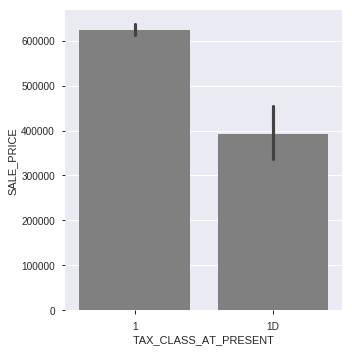

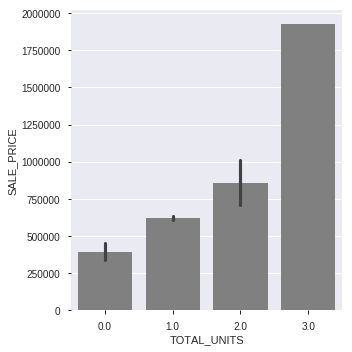

In [37]:
# create a loop for each features 'unique' count vs sale price and plot each with sns.catpot.
for col in sorted(train.columns):
    if (train[col].nunique() < 13) & (train[col].nunique() > 1):
        sns.catplot(x=col, y='SALE_PRICE', data = train, kind = 'bar', color = 'grey')
        plt.show()

### Numeric Feature vs Sale Price plotting.

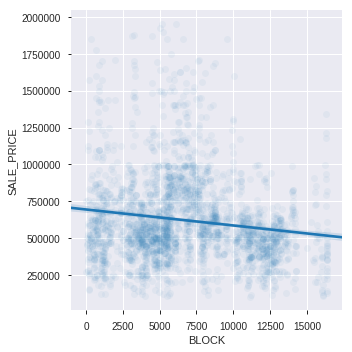

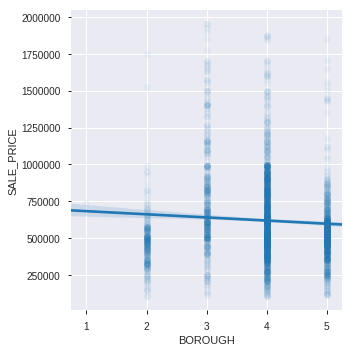

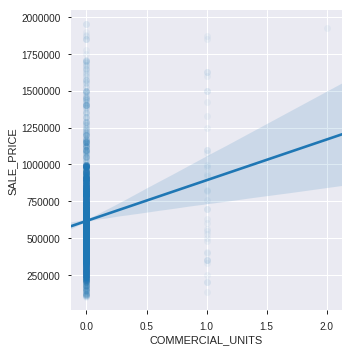

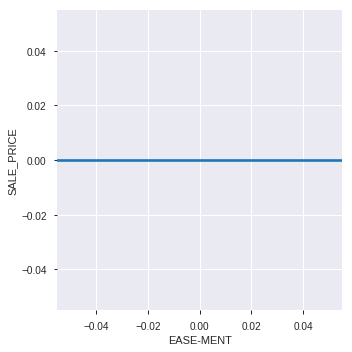

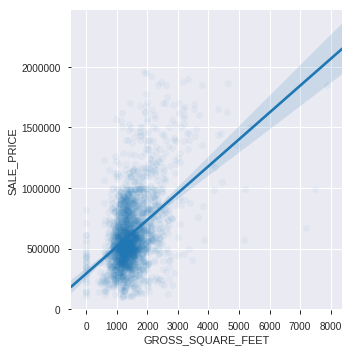

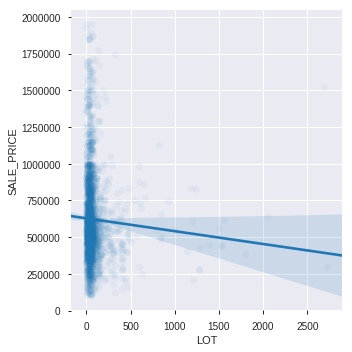

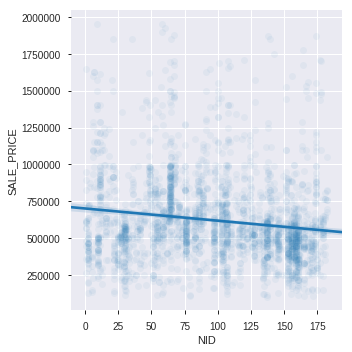

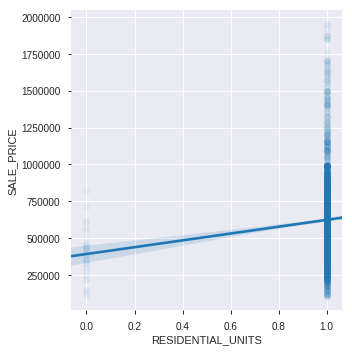

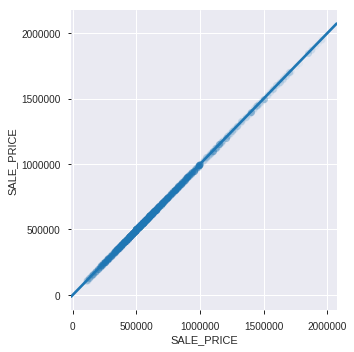

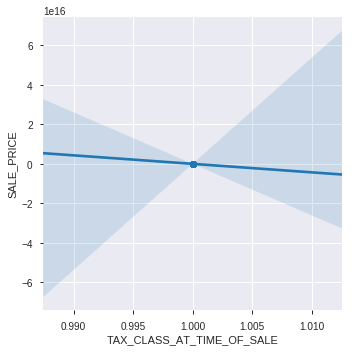

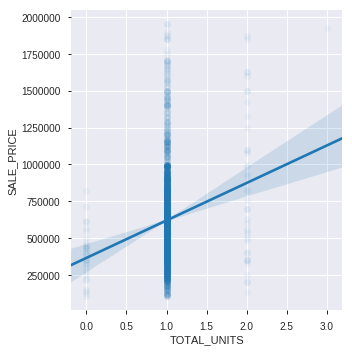

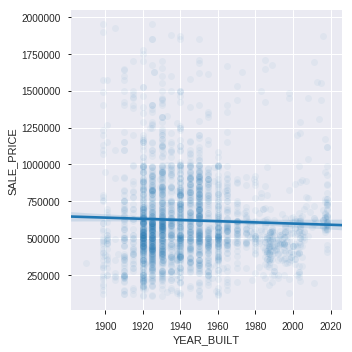

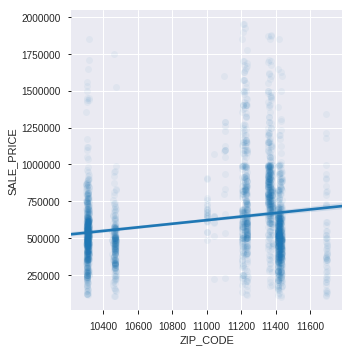

In [10]:
# plot just the numeric features vs the sale price with sns.lmplot.
numeric = train.select_dtypes('number')
for col in sorted(numeric.columns):
    sns.lmplot(x=col, y = 'SALE_PRICE', data = train, scatter_kws = dict(alpha=0.05))
    plt.show()

### KMeans Cluster Neighborhood Category Value Column 'NID'.

In [0]:
# imporrt KMeans from sklearn.cluster.
from sklearn.cluster import KMeans

In [0]:
# create the kmeans, # clusters, n jobs -1 for speed if running locally.
kmeans = KMeans(n_clusters=10, n_jobs = -1)
# split the train/test data on the 'NID' categories created for neighborhood.
train['cluster'] = kmeans.fit_predict(train[['NID']])
test['cluster'] = kmeans.predict(test[['NID']])
# show the 'clusters' vs 'sale price' in a scatter plot.
px.scatter(train, x='SALE_PRICE', y ='cluster')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy



### Scatter plot 'Neighborhood' vs 'Sale Price' with px.scatter.

In [0]:
# import plotly.express library.
import plotly.express as px 

In [0]:
# px.scatter train data, x= 'neighborhood', y = 'sale_price'.
px.scatter(train, x = 'NEIGHBORHOOD', y = 'SALE_PRICE')

### Create a Train/Test Subsets With Data Types 'Number' only, Drop NAs.

In [0]:
# create a subset of the data with just the feature type 'number', drop na's.
train_subset = train.select_dtypes('number').dropna(axis='columns')
test_subset  = test.select_dtypes('number').dropna(axis='columns')
assert all(train_subset.columns == test_subset.columns)
# set the target.
target = 'SALE_PRICE'
# set the features, drop tagert.
features = train_subset.columns.drop(target)
# create X_train and y_train.
X_train = train_subset[features]
y_train = train_subset[target]
# create X_test and y_test.
X_test  = test_subset[features]
y_test  = test_subset[target]
# show the shape of each data frame.
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((2507, 12), (2507,), (644, 12), (644,))

### Top 10 features Using SelectKBest and f_regression.

In [0]:
# import f_regression, SelectKBest from sklearn,feature_selection.
from sklearn.feature_selection import f_regression, SelectKBest

In [0]:
# select the 10 features that best correlate to the target.
# similar to the way we did linear regression last time.

# create selector with 'SelectKBest'(score_func=f_regression, k=10)
selector = SelectKBest(score_func=f_regression, k = 10)
# create a data set for X_train with 'selector.fit_transform'.
X_train_selected = selector.fit_transform(X_train, y_train)
# create a data set for y_test with 'selector.transform'.
X_test_selected = selector.transform(X_test)
# show the shape of the data frames.
X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal



((2507, 10), (644, 10))

In [0]:
# look at which features were selected for the top 10.

# create the column names from X_train.
all_names = X_train.columns
# create mask with '.get_support()'.
selected_mask = selector.get_support()
# group the 'selected names' from the column names in X_train.
selected_names = all_names[selected_mask]
# group the 'unselected names' from the column names in X_train.
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
print('Features not selected:')
for name in unselected_names:
    print(name)    


Features selected:
BOROUGH
BLOCK
LOT
ZIP_CODE
RESIDENTIAL_UNITS
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
NID
cluster


### Linear Regression Model on 'Top 10' Selected Features.

In [0]:
# import LinearRegression from sklearn.linear_model, import mean_absolute_error from sklearn.metrics.
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

In [0]:
# create the model with 'LinearRegression().
model = LinearRegression()
# fit the model on the X_train_selected and y_train.
model.fit(X_train_selected, y_train)
# create teh y_pred with '.predict'.
y_pred = model.predict(X_test_selected)
# create the 'mae' with 'mean_absolute_error' with y_test, y_pred.
mae = mean_absolute_error(y_test, y_pred)
# print the results with 0 decimals.
print(f'Test MAE: ${mae:,.0f}')

Test MAE: $167,787


### R-Squared and R-Sqaured-Adjust for Top 10 Selected.

In [0]:
# import statsmodel.api.
import statsmodels.api as sm

In [0]:
# try with r squared and r squared adjust.
# add intercept manually.

# add a 'constant' column of 1s to the X_train_selected data.
X1 = sm.add_constant(X_train_selected)
# create the 'result' by fitting the datawith 'sm.OLS(y_train, X1).fit()'.
result = sm.OLS(y_train, X1).fit()
print(result.rsquared, result.rsquared_adj)


0.3743430929726851 0.3720880220222462


### Mean Absolute Error for Each Feature in Test Data.

In [0]:
# create a loop to run through each X_train feature to show the 'Test MAE'.
for k in range(1, len(X_train.columns)+1):
  print(f'{k} features')
# create selector with 'SelectKBest'.
  selector = SelectKBest(score_func=f_regression, k=k)
# create X_train_selected, X_test_selected.
  X_train_selected = selector.fit_transform(X_train, y_train)
  X_test_selected = selector.transform(X_test)
# create model with 'LinearRegression()'.
  model = LinearRegression()
#fit the model.
  model.fit(X_train_selected, y_train)
# create the 'y_pred.
  y_pred = model.predict(X_test_selected)
# create the 'mae'.
  mae = mean_absolute_error(y_test, y_pred)
# show the results.
  print(f'Test MAE: ${mae:,.0f} ]\n')

1 features
Test MAE: $183,641 ]

2 features
Test MAE: $184,003 ]

3 features
Test MAE: $183,943 ]

4 features
Test MAE: $167,050 ]

5 features
Test MAE: $166,541 ]

6 features
Test MAE: $167,603 ]

7 features
Test MAE: $167,603 ]

8 features
Test MAE: $167,488 ]

9 features
Test MAE: $167,807 ]

10 features
Test MAE: $167,787 ]

11 features
Test MAE: $167,533 ]

12 features
Test MAE: $167,533 ]



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning:

invalid value encountered in true_divide

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in greater

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning:

invalid value encountered in less

/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning:

invalid value encountered in less_equal

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning:

divide by zero encountered in true_divide

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning:

invalid value encou